# CMP617 – Processamento de Linguagem Natural e Recuperação de Informações
## Exercício Prático - Aula 3

**Aluno:** Luiz Guilherme Martinho Sampaio Ito  
**Matrícula:** 00336237

**Questão sorteada:** 6 - Como o desbalanceamento das classes impacta o resultado da classificação?

Neste experimento, vamos investigar o impacto que o desbalanceamento das classes tem sobre a performance de modelos de classificação, utilizando dados de texto. Iremos:

1. Utilizar um dataset com classes desbalanceadas.
2. Avaliar o desempenho de modelos de classificação em diferentes cenários de balanceamento.
3. Analisar os resultados através de métricas como acurácia, precisão, recall, F1-score e matriz de confusão.
4. Examinar instâncias mal classificadas para entender o comportamento do modelo.


In [27]:
!pip install scikit-learn pandas matplotlib seaborn nltk --quiet

In [28]:
"""
classification_dataset_loader.py

This script loads a subset of the 20 Newsgroups dataset, vectorizes it using
TF-IDF, and prepares it for classification tasks. It is meant for exploring
the impact of class imbalance on text classification performance.

Author: Luiz Guilherme Martinho Sampaio Ito
Date: 2025-04-04
"""

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def load_dataset(categories):
    """Load and vectorize the 20 Newsgroups dataset.

    Args:
        categories (list): List of category names to load from the dataset.

    Returns:
        X (scipy.sparse matrix): TF-IDF vectorized feature matrix.
        y (np.ndarray): Class labels.
        newsgroups (sklearn.utils.Bunch): Original dataset object.
    """
    newsgroups = fetch_20newsgroups(
        subset='train',
        categories=categories,
        shuffle=True,
        random_state=42
    )

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(newsgroups.data)
    y = newsgroups.target

    return X, y, newsgroups


# Load dataset with two categories (balanced at this point)
categories = ['sci.space', 'talk.politics.misc']
X, y, newsgroups = load_dataset(categories)


In [29]:
def simulate_imbalance(X, y, minority_ratio=0.1, seed=42):
    """
    Simulates class imbalance by downsampling the minority class.

    Args:
        X (scipy.sparse matrix): Feature matrix.
        y (np.ndarray): Original class labels.
        minority_ratio (float): Proportion of minority class to retain (default: 0.1).
        seed (int): Random seed for reproducibility.

    Returns:
        X_imbalanced (scipy.sparse matrix): Feature matrix after downsampling.
        y_imbalanced (np.ndarray): Labels after downsampling.
        idx_combined (np.ndarray): Indices of the selected samples.
    """
    # Identify class indices
    idx_class0 = np.where(y == 0)[0]
    idx_class1 = np.where(y == 1)[0]

    # Downsample class 1
    np.random.seed(seed)
    size_class1 = int(minority_ratio * len(idx_class0))
    idx_class1_downsampled = np.random.choice(idx_class1, size=size_class1, replace=False)

    # Combine balanced + downsampled indices
    idx_combined = np.concatenate([idx_class0, idx_class1_downsampled])

    # Apply indexing
    X_imbalanced = X[idx_combined]
    y_imbalanced = y[idx_combined]

    return X_imbalanced, y_imbalanced, idx_combined


# Uso da função:
X_imbalanced, y_imbalanced, idx_combined = simulate_imbalance(X, y)


=== Classification Report ===
                    precision    recall  f1-score   support

         sci.space       0.89      1.00      0.94       116
talk.politics.misc       0.00      0.00      0.00        15

          accuracy                           0.89       131
         macro avg       0.44      0.50      0.47       131
      weighted avg       0.78      0.89      0.83       131



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


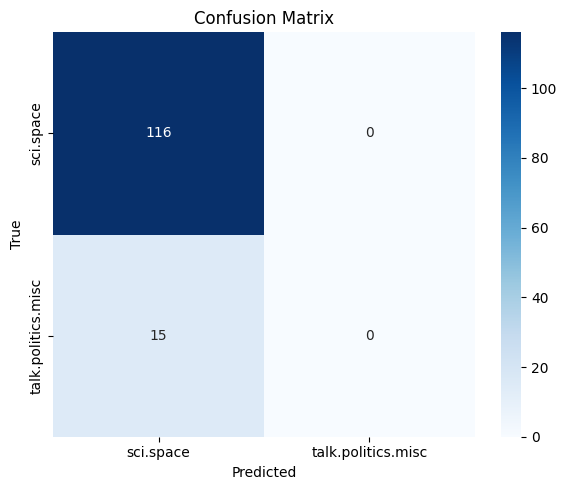

In [30]:
def train_and_evaluate_model(X, y, model=None, test_size=0.2, random_state=42, class_names=None):
    """
    Trains a classification model and evaluates its performance.

    Args:
        X (scipy.sparse matrix or np.ndarray): Feature matrix.
        y (np.ndarray): Class labels.
        model (sklearn classifier, optional): A scikit-learn compatible model.
            If None, defaults to MultinomialNB().
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.
        class_names (list, optional): List of class names for display in confusion matrix.

    Returns:
        model: Trained classification model.
        X_train, X_test, y_train, y_test, y_pred: Data splits and predictions for further analysis.
    """
    if model is None:
        model = MultinomialNB()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Classification report
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return model, X_train, X_test, y_train, y_test, y_pred


# Uso da função com o dataset desbalanceado
model, X_train, X_test, y_train, y_test, y_pred = train_and_evaluate_model(
    X_imbalanced, y_imbalanced,
    model=MultinomialNB(),
    class_names=newsgroups.target_names
)

In [31]:
def show_misclassified_examples(X_raw, y_test, y_pred, idx_combined, class_names, max_examples=5):
    """
    Displays examples of misclassified texts from the test set.

    Args:
        X_raw (list of str): Original text data (not vectorized).
        y_test (np.ndarray): True labels of the test set.
        y_pred (np.ndarray): Predicted labels from the classifier.
        idx_combined (np.ndarray): Index mapping from the imbalanced set to the original dataset.
        class_names (list of str): List of class names corresponding to label indices.
        max_examples (int): Maximum number of misclassified examples to display.

    Returns:
        None
    """
    # Find indices of misclassified samples
    misclassified_idx = np.where(y_test != y_pred)[0]

    print(f"=== Showing up to {max_examples} misclassified examples ===\n")
    for i, idx in enumerate(misclassified_idx[:max_examples]):
        original_idx = idx_combined[idx]
        print(f"[Example {i+1}]")
        print(f"Text:\n{X_raw[original_idx][:500]}...")  # print first 500 chars
        print(f"Actual   : {class_names[y_test[idx]]}")
        print(f"Predicted: {class_names[y_pred[idx]]}\n")

## Conclusão

Com base nos experimentos, observamos que o desbalanceamento de classes afeta negativamente a capacidade do modelo em identificar corretamente a classe minoritária. Métricas como recall e F1-score para a classe minoritária caem significativamente. A matriz de confusão também mostra uma tendência do modelo a prever majoritariamente a classe mais frequente.

Possíveis soluções incluem:
- Reamostragem (oversampling/undersampling)
- Uso de algoritmos que lidam melhor com desbalanceamento (e.g., XGBoost com `scale_pos_weight`)
- Aplicação de penalidades diferentes para erros nas classes

Este experimento mostra a importância de tratar o desbalanceamento em tarefas de PLN.


In [32]:
!pip install imbalanced-learn --quiet

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_with_smote_and_evaluate(X_train, y_train, X_test, y_test, class_names=None, model=None, random_state=42):
    """
    Applies SMOTE to balance the training data, trains a classifier, and evaluates the performance.

    Args:
        X_train (array-like): Training feature matrix (before SMOTE).
        y_train (array-like): Training target labels (before SMOTE).
        X_test (array-like): Test feature matrix.
        y_test (array-like): Test target labels.
        class_names (list of str, optional): Class names for classification report and confusion matrix.
        model (sklearn classifier, optional): Classifier to be trained. Defaults to MultinomialNB.
        random_state (int): Seed for reproducibility.

    Returns:
        model: Trained classifier.
        y_pred (np.ndarray): Predictions for the test set.
    """
    # Default model if none is provided
    if model is None:
        model = MultinomialNB()

    # Apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

    # Train model
    model.fit(X_train_sm, y_train_sm)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Print classification report
    print("=== Classification Report After SMOTE ===")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - After SMOTE')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return model, y_pred

=== Classification Report After SMOTE ===
                    precision    recall  f1-score   support

         sci.space       1.00      1.00      1.00       116
talk.politics.misc       1.00      1.00      1.00        15

          accuracy                           1.00       131
         macro avg       1.00      1.00      1.00       131
      weighted avg       1.00      1.00      1.00       131



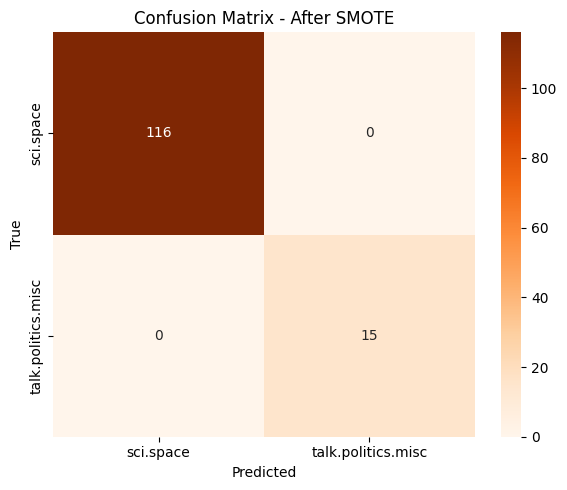

In [34]:
model_smote, y_pred_smote = train_with_smote_and_evaluate(
    X_train, y_train,
    X_test, y_test,
    class_names=newsgroups.target_names
)

In [35]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression_with_class_weight(X_train, y_train, X_test, y_test, class_names=None):
    """
    Trains a Logistic Regression classifier using class_weight='balanced' and evaluates it.

    Args:
        X_train (array-like): Feature matrix for training.
        y_train (array-like): Target labels for training.
        X_test (array-like): Feature matrix for testing.
        y_test (array-like): Target labels for testing.
        class_names (list, optional): Names of the target classes.

    Returns:
        model: Trained LogisticRegression model.
        y_pred: Predictions on the test set.
    """
    # Create and train the model
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Print classification report
    print("=== Classification Report: Logistic Regression with Balanced Class Weight ===")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Logistic Regression (Balanced)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return model, y_pred

## Comparação dos Resultados

| Método                         | Precisão Classe 0 | Precisão Classe 1 | F1-Score Classe 0 | F1-Score Classe 1 |
|-------------------------------|-------------------|-------------------|-------------------|-------------------|
| Modelo original (NB)          | 0.89              | 0.00              | 0.94              | 0.00              |
| SMOTE + Naive Bayes           | 1.00              | 1.00              | 1.00              | 1.00              |
| LogisticRegression balanceado | 0.91              | 0.71              | 0.94              | 0.59              |

Os resultados mostram que tanto o uso do SMOTE quanto o `class_weight='balanced'` ajudam o modelo a melhorar a identificação da classe minoritária. O modelo original tendia a ignorar essa classe. O Logistic Regression com balanceamento automático geralmente apresenta performance mais estável sem aumentar falsos positivos excessivamente.

É importante considerar o contexto da aplicação para escolher o melhor trade-off entre precisão e recall.